In [1]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torch.nn.utils import rnn as rnn_utils

from data_generation.square_sequences import generate_sequences
from stepbystep.v4 import StepByStep
from plots.ch_8 import *

## Sequences ##

**Data Generation**

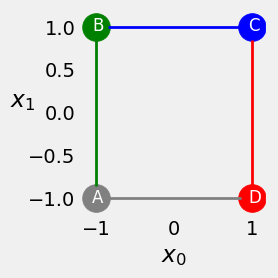

In [2]:
fig = counter_vs_clock(draw_arrows=False)

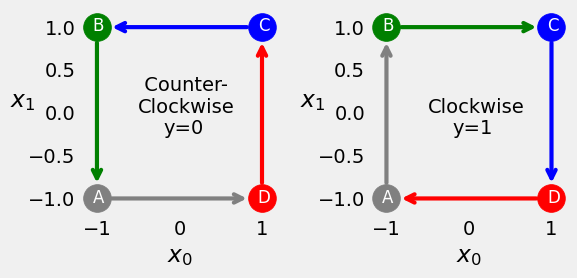

In [3]:
fig = counter_vs_clock()

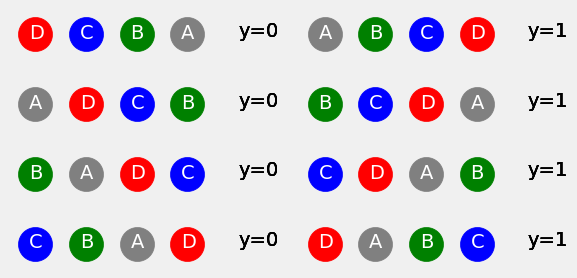

In [4]:
fig = plot_sequences()

In [5]:
points, directions = generate_sequences(n=128, seed=13)

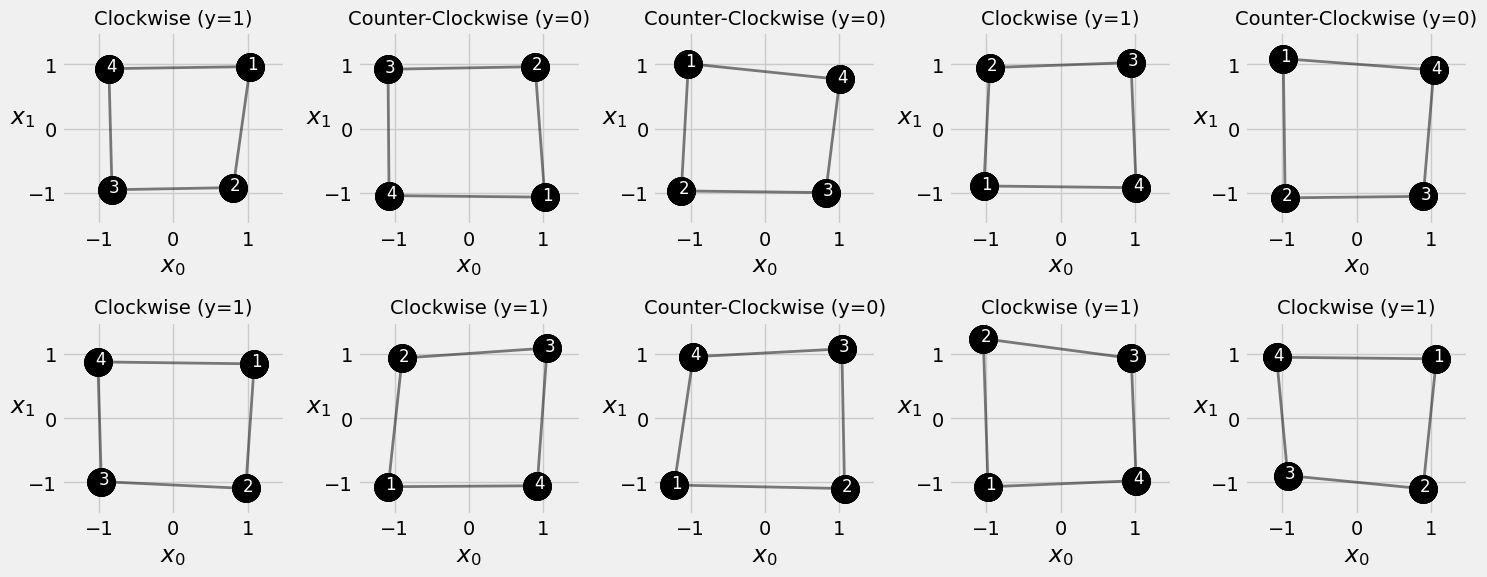

In [6]:
fig = plot_data(points, directions)

## Recurrent Neural Networks (RNNs) ##

In [7]:
hidden_state = torch.zeros(2)
hidden_state

tensor([0., 0.])

**RNN Cell**

In [8]:
n_features = 2
hidden_dim = 2

torch.manual_seed(19)
rnn_cell = nn.RNNCell(input_size=n_features, hidden_size=hidden_dim)
rnn_state = rnn_cell.state_dict()
rnn_state

OrderedDict([('weight_ih',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih', tensor([0.4954, 0.6533])),
             ('bias_hh', tensor([-0.3565, -0.2904]))])

In [9]:
linear_input = nn.Linear(n_features, hidden_dim)
linear_hidden = nn.Linear(hidden_dim, hidden_dim)

with torch.no_grad():
    linear_input.weight = nn.Parameter(rnn_state['weight_ih'])
    linear_input.bias = nn.Parameter(rnn_state['bias_ih'])
    linear_hidden.weight = nn.Parameter(rnn_state['weight_hh'])
    linear_hidden.bias = nn.Parameter(rnn_state['bias_hh'])

In [10]:
initial_hidden = torch.zeros(1, hidden_dim)
initial_hidden

tensor([[0., 0.]])

In [11]:
th = linear_hidden(initial_hidden)
th

tensor([[-0.3565, -0.2904]], grad_fn=<AddmmBackward0>)

In [12]:
X = torch.as_tensor(points[0]).float()
X

tensor([[ 1.0349,  0.9661],
        [ 0.8055, -0.9169],
        [-0.8251, -0.9499],
        [-0.8670,  0.9342]])

In [13]:
tx = linear_input(X[0:1])
tx

tensor([[0.7712, 1.4310]], grad_fn=<AddmmBackward0>)

In [14]:
adding = th + tx
adding

tensor([[0.4146, 1.1405]], grad_fn=<AddBackward0>)

In [15]:
torch.tanh(adding)

tensor([[0.3924, 0.8146]], grad_fn=<TanhBackward0>)

In [16]:
rnn_cell(X[0:1])

tensor([[0.3924, 0.8146]], grad_fn=<TanhBackward0>)

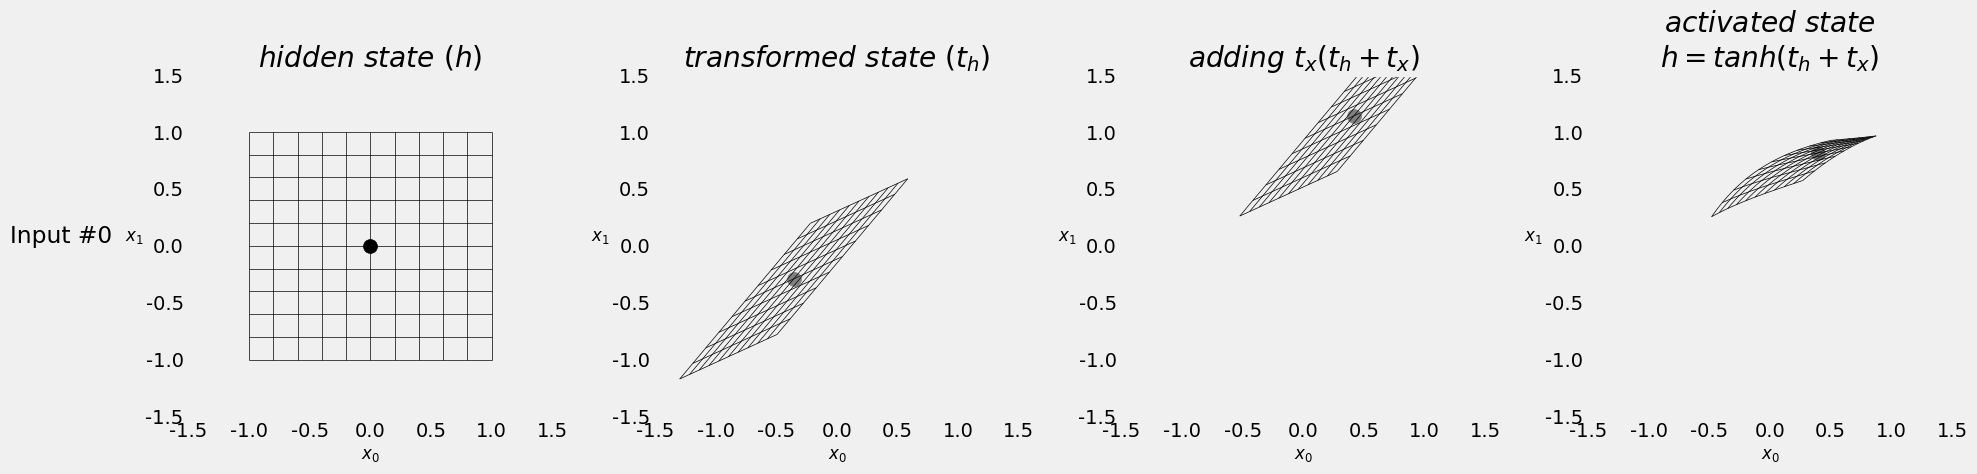

In [17]:
fig = figure8(linear_hidden, linear_input, X)

In [18]:
# WRONG
rnn_cell(X)

tensor([[ 0.3924,  0.8146],
        [ 0.7864,  0.5266],
        [-0.0047, -0.2897],
        [-0.6817,  0.1109]], grad_fn=<TanhBackward0>)

In [19]:
hidden = torch.zeros(1, hidden_dim)
for i in range(X.shape[0]):
    out = rnn_cell(X[i:i+1], hidden)
    print(out)
    hidden = out

tensor([[0.3924, 0.8146]], grad_fn=<TanhBackward0>)
tensor([[ 0.4347, -0.0481]], grad_fn=<TanhBackward0>)
tensor([[-0.1521, -0.3367]], grad_fn=<TanhBackward0>)
tensor([[-0.5297,  0.3551]], grad_fn=<TanhBackward0>)


**RNN Layer**

In [20]:
n_features = 2
hidden_dim = 2

torch.manual_seed(19)
rnn = nn.RNN(input_size=n_features, hidden_size=hidden_dim)
rnn.state_dict()

OrderedDict([('weight_ih_l0',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh_l0',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih_l0', tensor([0.4954, 0.6533])),
             ('bias_hh_l0', tensor([-0.3565, -0.2904]))])

**Shapes**

In [21]:
batch = torch.as_tensor(points[:3]).float()
batch.shape

/tmp/ipykernel_18739/3502642561.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  batch = torch.as_tensor(points[:3]).float()


torch.Size([3, 4, 2])

In [22]:
permuted_batch = batch.permute(1, 0, 2)
permuted_batch.shape

torch.Size([4, 3, 2])

In [23]:
torch.manual_seed(19)
rnn = nn.RNN(input_size=n_features, hidden_size=hidden_dim)
out, final_hidden = rnn(permuted_batch)
out.shape, final_hidden.shape

(torch.Size([4, 3, 2]), torch.Size([1, 3, 2]))

In [24]:
(out[-1] == final_hidden).all()

tensor(True)

In [25]:
batch_hidden = final_hidden.permute(1, 0, 2)
batch.shape

torch.Size([3, 4, 2])

In [27]:
torch.manual_seed(19)
rnn_batch_first = nn.RNN(input_size=n_features, hidden_size=hidden_dim, batch_first=True)
out, final_hidden = rnn_batch_first(batch)
out.shape, final_hidden.shape

(torch.Size([3, 4, 2]), torch.Size([1, 3, 2]))

**Stacked RNN**

In [28]:
torch.manual_seed(19)
rnn_stacked = nn.RNN(input_size=2, hidden_size=2, num_layers=2, batch_first=True)
state = rnn_stacked.state_dict()
state

OrderedDict([('weight_ih_l0',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh_l0',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih_l0', tensor([0.4954, 0.6533])),
             ('bias_hh_l0', tensor([-0.3565, -0.2904])),
             ('weight_ih_l1',
              tensor([[-0.6701, -0.5811],
                      [-0.0170, -0.5856]])),
             ('weight_hh_l1',
              tensor([[ 0.1159, -0.6978],
                      [ 0.3241, -0.0983]])),
             ('bias_ih_l1', tensor([-0.3163, -0.2153])),
             ('bias_hh_l1', tensor([ 0.0722, -0.3242]))])

In [29]:
rnn_layer0 = nn.RNN(input_size=2, hidden_size=2, batch_first=True)
rnn_layer1 = nn.RNN(input_size=2, hidden_size=2, batch_first=True)

rnn_layer0.load_state_dict(dict(list(state.items())[:4]))
rnn_layer1.load_state_dict(dict([(k[:-1]+'0', v) for k, v in list(state.items())[4:]]))

<All keys matched successfully>

In [30]:
x = torch.as_tensor(points[0:1]).float()

In [31]:
out0, h0 = rnn_layer0(x)

In [32]:
out1, h1 = rnn_layer1(out0)

In [33]:
out1, torch.cat([h0, h1])

(tensor([[[-0.7533, -0.7711],
          [-0.0566, -0.5960],
          [ 0.4324, -0.2908],
          [ 0.1563, -0.5152]]], grad_fn=<TransposeBackward1>),
 tensor([[[-0.5297,  0.3551]],
 
         [[ 0.1563, -0.5152]]], grad_fn=<CatBackward0>))

In [34]:
out, hidden = rnn_stacked(x)
out, hidden

(tensor([[[-0.7533, -0.7711],
          [-0.0566, -0.5960],
          [ 0.4324, -0.2908],
          [ 0.1563, -0.5152]]], grad_fn=<TransposeBackward1>),
 tensor([[[-0.5297,  0.3551]],
 
         [[ 0.1563, -0.5152]]], grad_fn=<StackBackward0>))

In [35]:
(out[:, -1] == hidden.permute(1, 0, 2)[:, -1]).all()

tensor(True)

**Bidirectional RNN**

In [36]:
torch.manual_seed(19)
rnn_bidirect = nn.RNN(input_size=2, hidden_size=2, bidirectional=True, batch_first=True)
state = rnn_bidirect.state_dict()
state

OrderedDict([('weight_ih_l0',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh_l0',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih_l0', tensor([0.4954, 0.6533])),
             ('bias_hh_l0', tensor([-0.3565, -0.2904])),
             ('weight_ih_l0_reverse',
              tensor([[-0.6701, -0.5811],
                      [-0.0170, -0.5856]])),
             ('weight_hh_l0_reverse',
              tensor([[ 0.1159, -0.6978],
                      [ 0.3241, -0.0983]])),
             ('bias_ih_l0_reverse', tensor([-0.3163, -0.2153])),
             ('bias_hh_l0_reverse', tensor([ 0.0722, -0.3242]))])

In [37]:
rnn_forward = nn.RNN(input_size=2, hidden_size=2, batch_first=True)
rnn_reverse = nn.RNN(input_size=2, hidden_size=2, batch_first=True)

rnn_forward.load_state_dict(dict(list(state.items())[:4]))
rnn_reverse.load_state_dict(dict([(k[:-8], v) for k, v in list(state.items())[4:]]))

<All keys matched successfully>

In [38]:
x_rev = torch.flip(x, dims=[1]) # N, L, F
x_rev

tensor([[[-0.8670,  0.9342],
         [-0.8251, -0.9499],
         [ 0.8055, -0.9169],
         [ 1.0349,  0.9661]]])

In [39]:
out, h = rnn_forward(x)
out_rev, h_rev = rnn_reverse(x_rev)
out_rev_back = torch.flip(out_rev, dims=[1])

In [40]:
torch.cat([out, out_rev_back], dim=2), torch.cat([h, h_rev])

(tensor([[[ 0.3924,  0.8146, -0.9355, -0.8353],
          [ 0.4347, -0.0481, -0.1766,  0.2596],
          [-0.1521, -0.3367,  0.8829,  0.0425],
          [-0.5297,  0.3551, -0.2032, -0.7901]]], grad_fn=<CatBackward0>),
 tensor([[[-0.5297,  0.3551]],
 
         [[-0.9355, -0.8353]]], grad_fn=<CatBackward0>))

In [41]:
out, hidden = rnn_bidirect(x)
out, hidden

(tensor([[[ 0.3924,  0.8146, -0.9355, -0.8353],
          [ 0.4347, -0.0481, -0.1766,  0.2596],
          [-0.1521, -0.3367,  0.8829,  0.0425],
          [-0.5297,  0.3551, -0.2032, -0.7901]]], grad_fn=<TransposeBackward1>),
 tensor([[[-0.5297,  0.3551]],
 
         [[-0.9355, -0.8353]]], grad_fn=<StackBackward0>))

In [42]:
out[:, -1] == hidden.permute(1, 0, 2).view(1, -1)

tensor([[ True,  True, False, False]])

**Square Model**

**Data Generation**

In [43]:
test_points, test_directions = generate_sequences(seed=19)

**Data Preparation**

In [44]:
train_data = TensorDataset(torch.as_tensor(points).float(), 
                           torch.as_tensor(directions).view(-1, 1).float())
test_data = TensorDataset(torch.as_tensor(test_points).float(),
                          torch.as_tensor(test_directions).view(-1, 1).float())

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

## Model Configuration ##

In [45]:
class SquareModel(nn.Module):
    def __init__(self, n_features, hidden_dim, n_outputs):
        super(SquareModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.hidden = None
        # Simple RNN
        self.basic_rnn = nn.RNN(self.n_features, self.hidden_dim, batch_first=True)
        # Classifier to produce as many logits as outputs
        self.classifier = nn.Linear(self.hidden_dim, self.n_outputs)
                
    def forward(self, X):
        # X is batch first (N, L, F)
        # output is (N, L, H)
        # final hidden state is (1, N, H)
        batch_first_output, self.hidden = self.basic_rnn(X)
        
        # only last item in sequence (N, 1, H)
        last_output = batch_first_output[:, -1]
        # classifier will output (N, 1, n_outputs)
        out = self.classifier(last_output)
        
        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)

In [46]:
torch.manual_seed(21)
model = SquareModel(n_features=2, hidden_dim=2, n_outputs=1)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

**Model Training**

In [47]:
sbs_rnn = StepByStep(model, loss, optimizer)
sbs_rnn.set_loaders(train_loader, test_loader)
sbs_rnn.train(100)

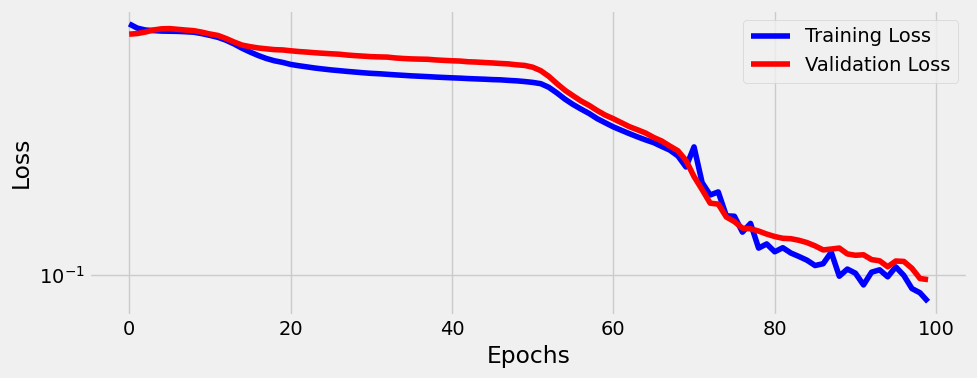

In [48]:
fig = sbs_rnn.plot_losses()

## Visualizing the Model ##

**Transformed Inputs**

In [50]:
state = model.basic_rnn.state_dict()
state['weight_ih_l0'], state['bias_ih_l0']

(tensor([[-0.5201, -2.6582],
         [-1.7018, -0.4989]], device='cuda:0'),
 tensor([0.8096, 0.8822], device='cuda:0'))

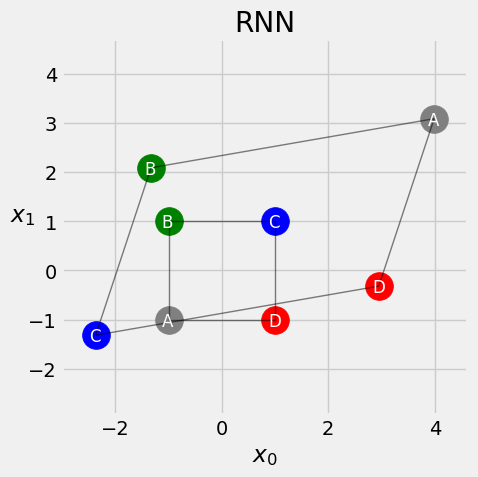

In [51]:
fig = figure13(model.basic_rnn)

**Hidden States**

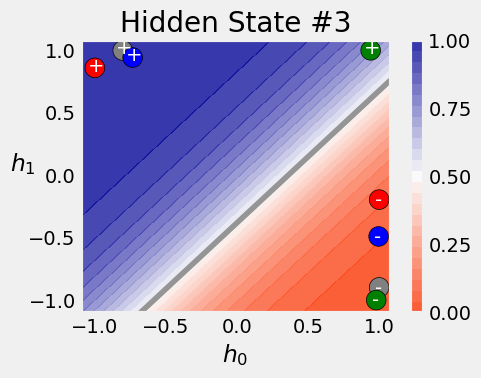

In [52]:
fig = canonical_contour(model)

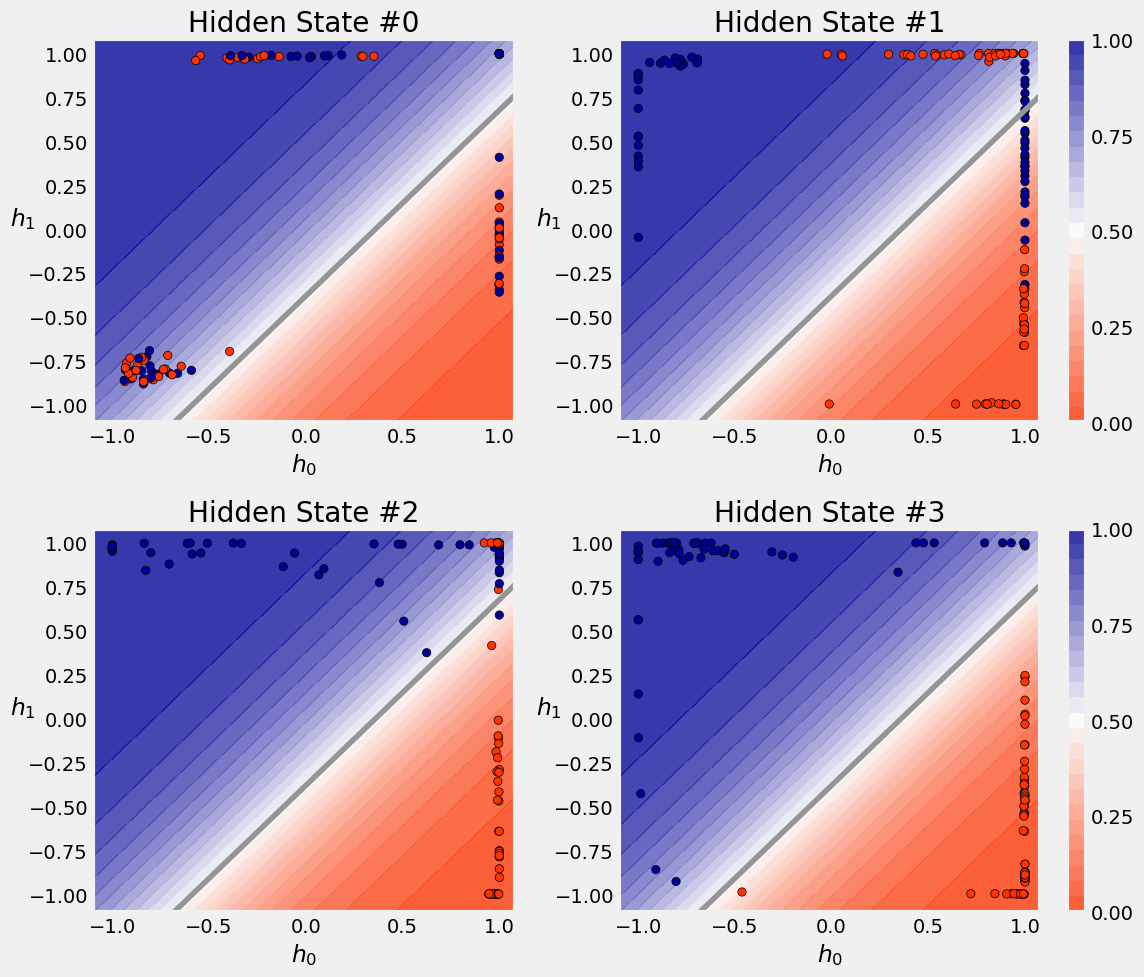

In [53]:
fig = hidden_states_contour(model, points, directions)

**The Journey of a Hidden State**

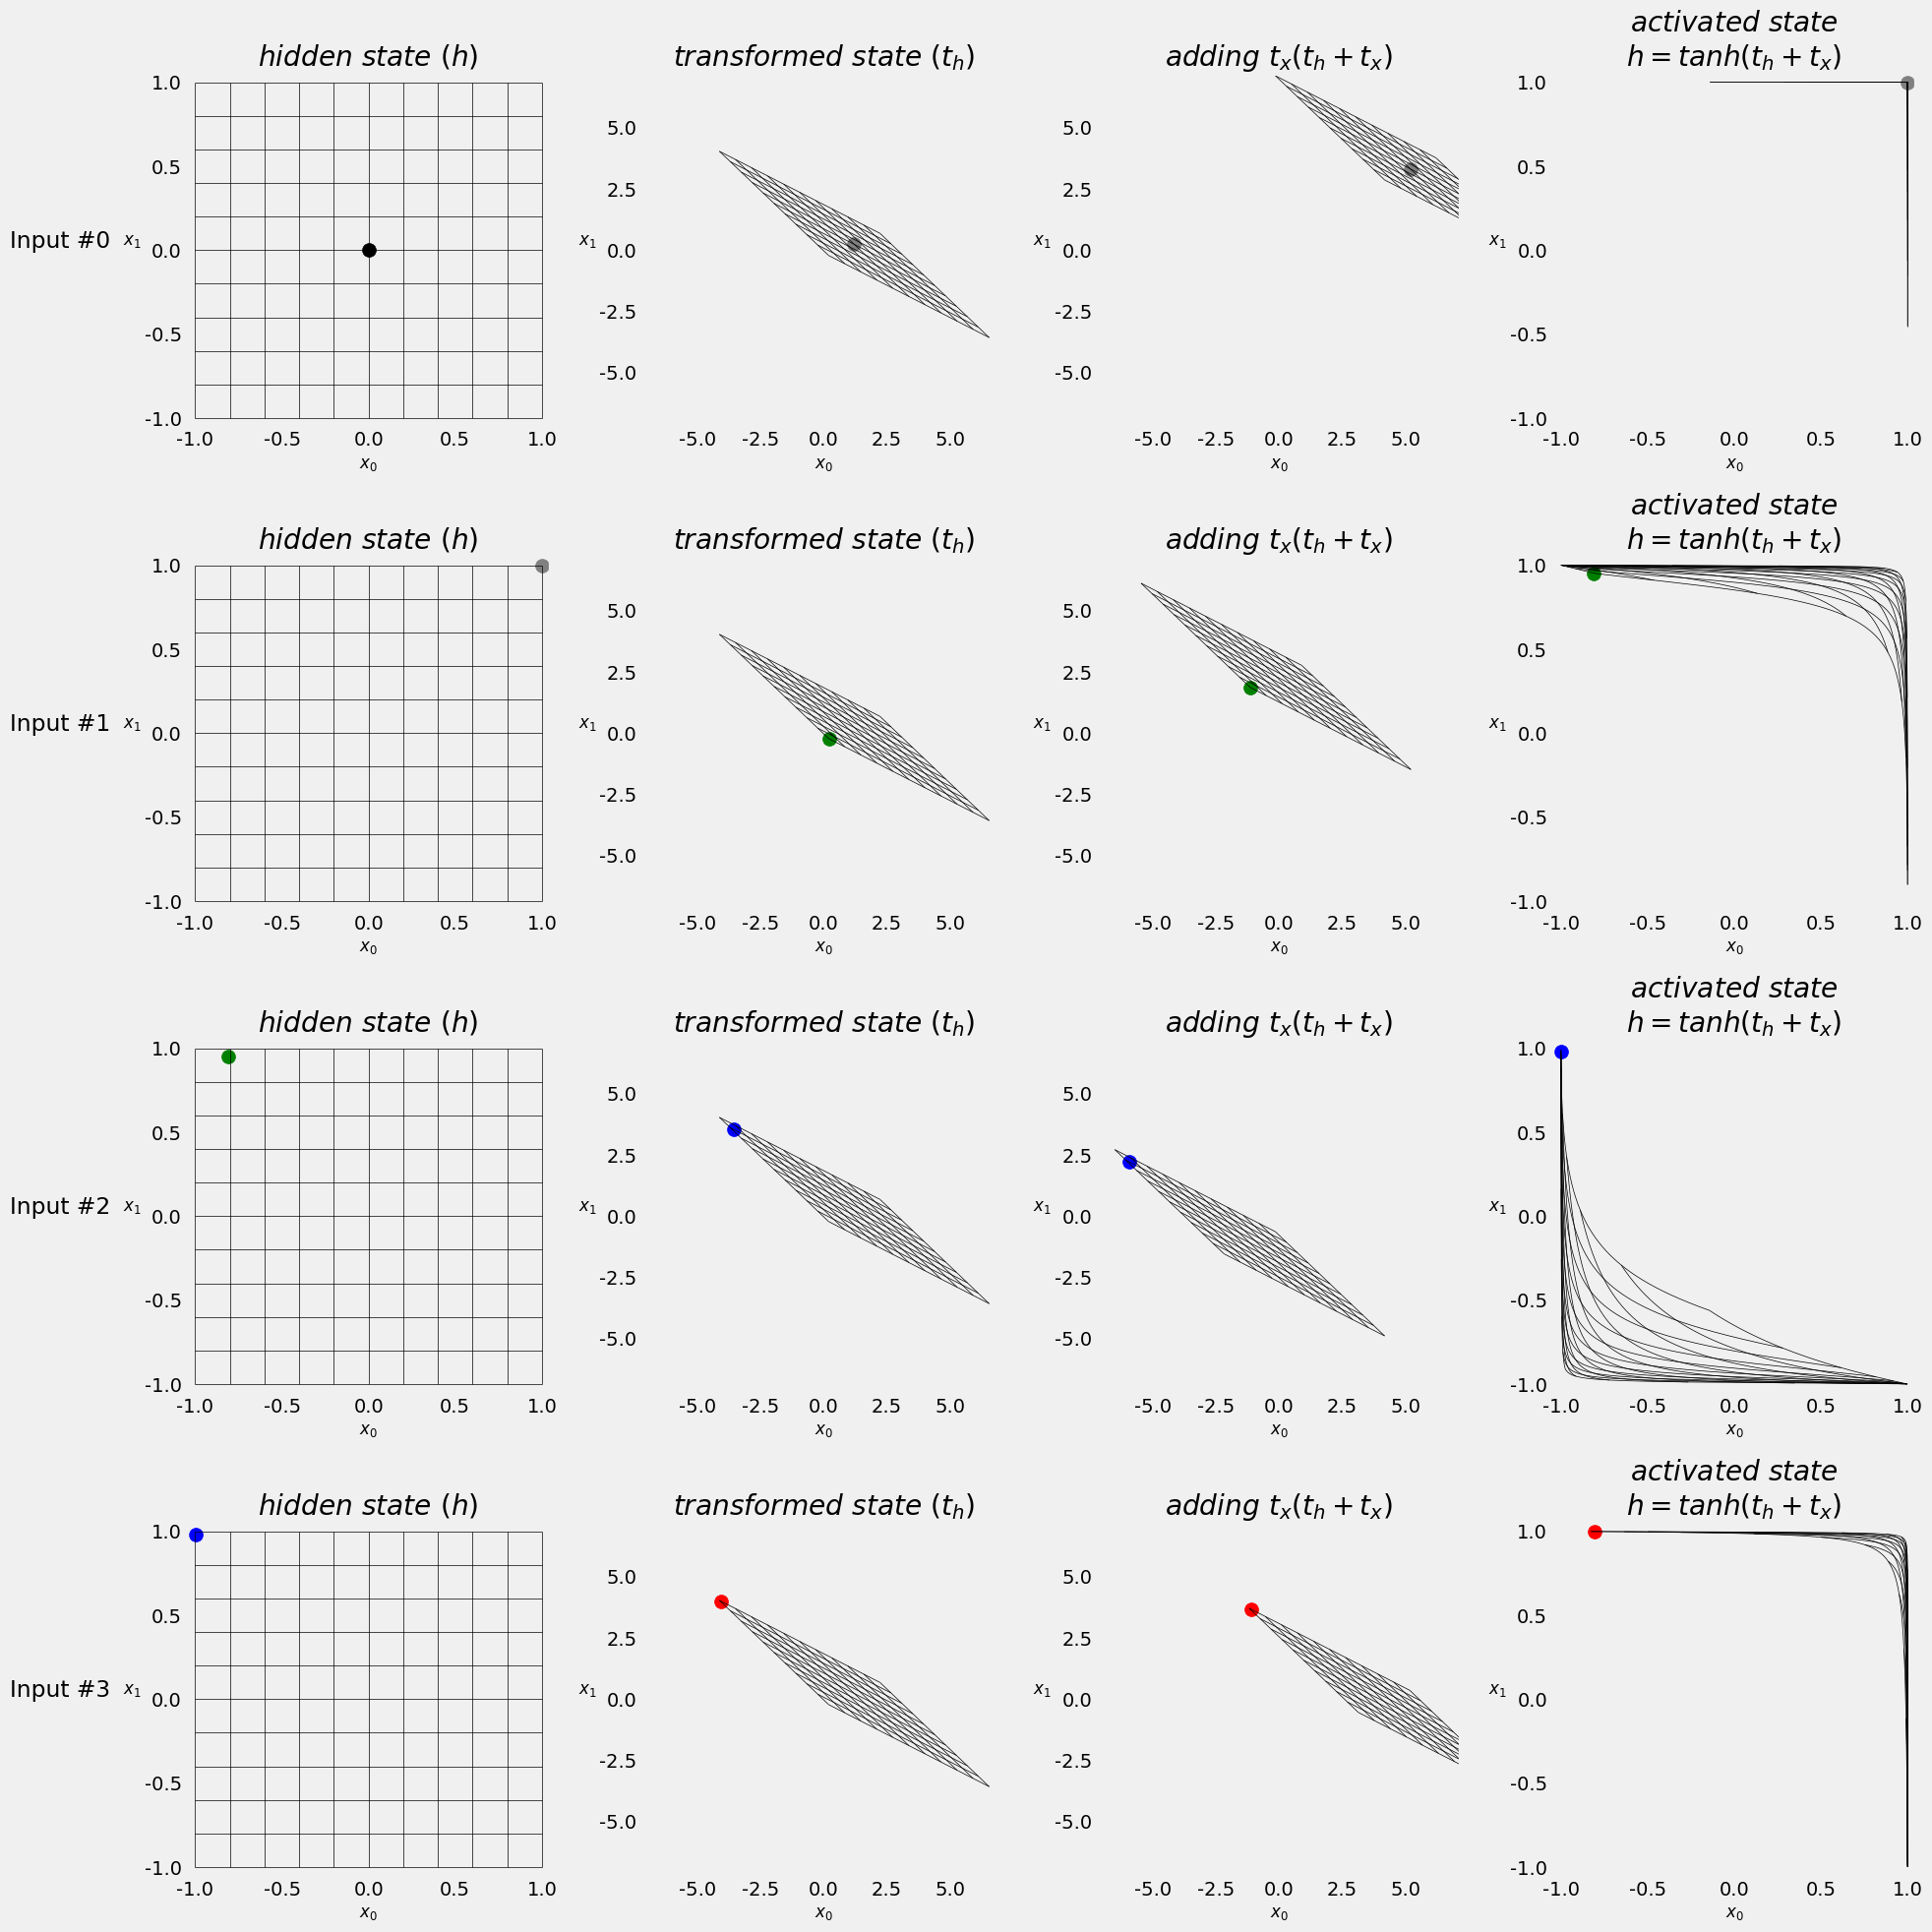

In [54]:
fig = figure16(model.basic_rnn)

In [55]:
square = torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2)
model(square.to(sbs_rnn.device))
model.hidden

tensor([[[-0.8039,  0.9987]]], device='cuda:0', grad_fn=<CudnnRnnBackward0>)

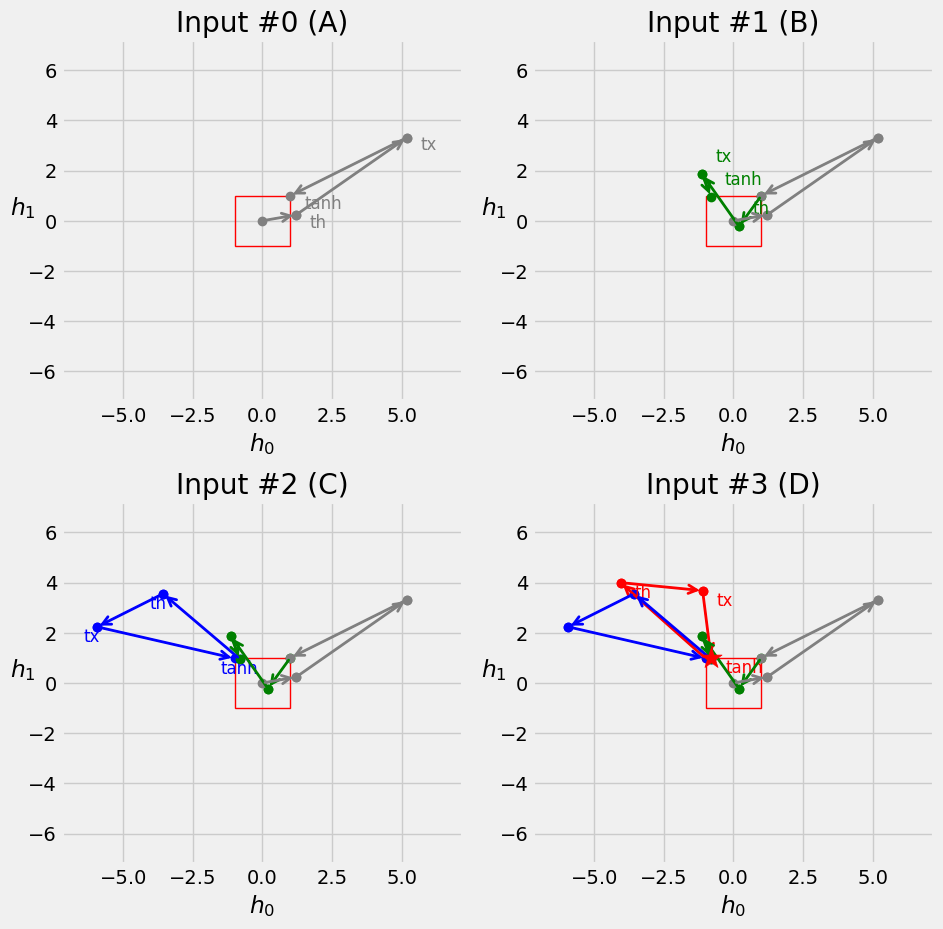

In [56]:
fig = figure17(model.basic_rnn)

## Gated Recurrent Units (GRUs) ##

In [57]:
n_features = 2
hidden_dim = 2

torch.manual_seed(17)
gru_cell = nn.GRUCell(input_size=n_features, hidden_size=hidden_dim)
gru_state = gru_cell.state_dict()
gru_state

OrderedDict([('weight_ih',
              tensor([[-0.0930,  0.0497],
                      [ 0.4670, -0.5319],
                      [-0.6656,  0.0699],
                      [-0.1662,  0.0654],
                      [-0.0449, -0.6828],
                      [-0.6769, -0.1889]])),
             ('weight_hh',
              tensor([[-0.4167, -0.4352],
                      [-0.2060, -0.3989],
                      [-0.7070, -0.5083],
                      [ 0.1418,  0.0930],
                      [-0.5729, -0.5700],
                      [-0.1818, -0.6691]])),
             ('bias_ih',
              tensor([-0.4316,  0.4019,  0.1222, -0.4647, -0.5578,  0.4493])),
             ('bias_hh',
              tensor([-0.6800,  0.4422, -0.3559, -0.0279,  0.6553,  0.2918]))])

In [58]:
Wx, bx = gru_state['weight_ih'], gru_state['bias_ih']
Wh, bh = gru_state['weight_hh'], gru_state['bias_hh']

print(Wx.shape, Wh.shape)
print(bx.shape, bh.shape)

torch.Size([6, 2]) torch.Size([6, 2])
torch.Size([6]) torch.Size([6])


In [59]:
Wxr, Wxz, Wxn = Wx.split(hidden_dim, dim=0)
bxr, bxz, bxn = bx.split(hidden_dim, dim=0)

Whr, Whz, Whn = Wh.split(hidden_dim, dim=0)
bhr, bhz, bhn = bh.split(hidden_dim, dim=0)

Wxr, bxr

(tensor([[-0.0930,  0.0497],
         [ 0.4670, -0.5319]]),
 tensor([-0.4316,  0.4019]))

In [60]:
def linear_layers(Wx, bx, Wh, bh):
    hidden_dim, n_features = Wx.size()    
    lin_input = nn.Linear(n_features, hidden_dim)
    lin_input.load_state_dict({'weight': Wx, 'bias': bx})
    lin_hidden = nn.Linear(hidden_dim, hidden_dim)
    lin_hidden.load_state_dict({'weight': Wh, 'bias': bh})
    return lin_hidden, lin_input

r_hidden, r_input = linear_layers(Wxr, bxr, Whr, bhr) # reset gate - red
z_hidden, z_input = linear_layers(Wxz, bxz, Whz, bhz) # update gate - blue
n_hidden, n_input = linear_layers(Wxn, bxn, Whn, bhn) # candidate state - black

In [61]:
def reset_gate(h, x):
    thr = r_hidden(h)
    txr = r_input(x)
    r = torch.sigmoid(thr + txr)
    return r  # red
    
def update_gate(h, x):
    thz = z_hidden(h)
    txz = z_input(x)
    z = torch.sigmoid(thz + txz)
    return z  # blue
    
def candidate_n(h, x, r):
    thn = n_hidden(h)
    txn = n_input(x)
    n = torch.tanh(r * thn + txn)
    return n  # black

In [62]:
initial_hidden = torch.zeros(1, hidden_dim)
X = torch.as_tensor(points[0]).float()
first_corner = X[0:1]

In [63]:
r = reset_gate(initial_hidden, first_corner)
r

tensor([[0.2387, 0.6928]], grad_fn=<SigmoidBackward0>)

In [64]:
n = candidate_n(initial_hidden, first_corner, r)
n

tensor([[-0.8032, -0.2275]], grad_fn=<TanhBackward0>)

In [65]:
z = update_gate(initial_hidden, first_corner)
z

tensor([[0.2984, 0.3540]], grad_fn=<SigmoidBackward0>)

In [66]:
h_prime = n*(1-z) + initial_hidden*z
h_prime

tensor([[-0.5635, -0.1470]], grad_fn=<AddBackward0>)

In [67]:
gru_cell(first_corner)

tensor([[-0.5635, -0.1470]], grad_fn=<AddBackward0>)

## GRU Layer ##

**Square Model II: The Quickening**

In [68]:
class SquareModelGRU(nn.Module):
    def __init__(self, n_features, hidden_dim, n_outputs):
        super(SquareModelGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.hidden = None
        # Simple GRU
        self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True)
        # Classifier to produce as many logits as outputs
        self.classifier = nn.Linear(self.hidden_dim, self.n_outputs)
                
    def forward(self, X):
        # X is batch first (N, L, F)
        # output is (N, L, H)
        # final hidden state is (1, N, H)
        batch_first_output, self.hidden = self.basic_rnn(X)
        
        # only last item in sequence (N, 1, H)
        last_output = batch_first_output[:, -1]
        # classifier will output (N, 1, n_outputs)
        out = self.classifier(last_output)
        
        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)   

**Model Configuration & Training**

In [69]:
torch.manual_seed(21)
model = SquareModelGRU(n_features=2, hidden_dim=2, n_outputs=1)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [70]:
sbs_gru = StepByStep(model, loss, optimizer)
sbs_gru.set_loaders(train_loader, test_loader)
sbs_gru.train(100)

## Visualizing the Model ##

**Hidden States**

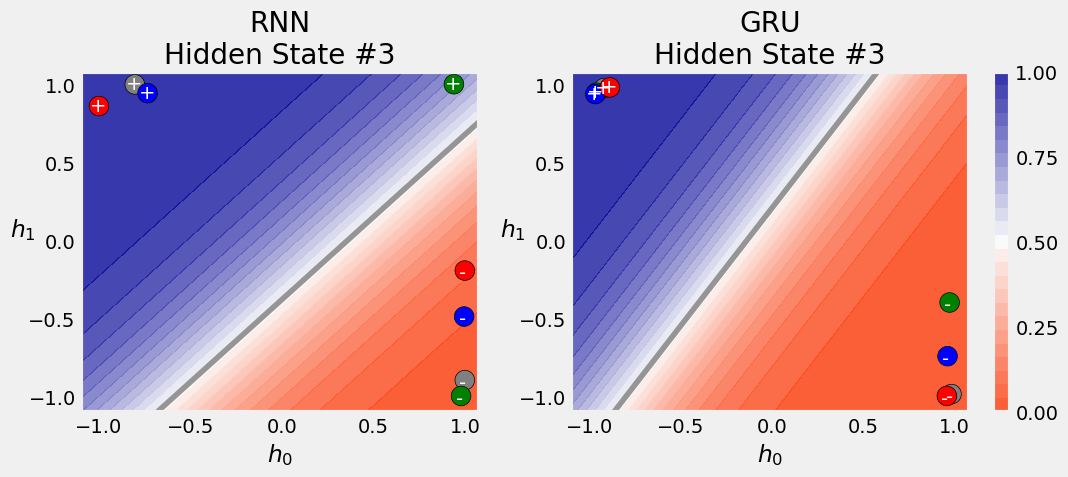

In [71]:
fig = figure20(sbs_rnn.model, sbs_gru.model)

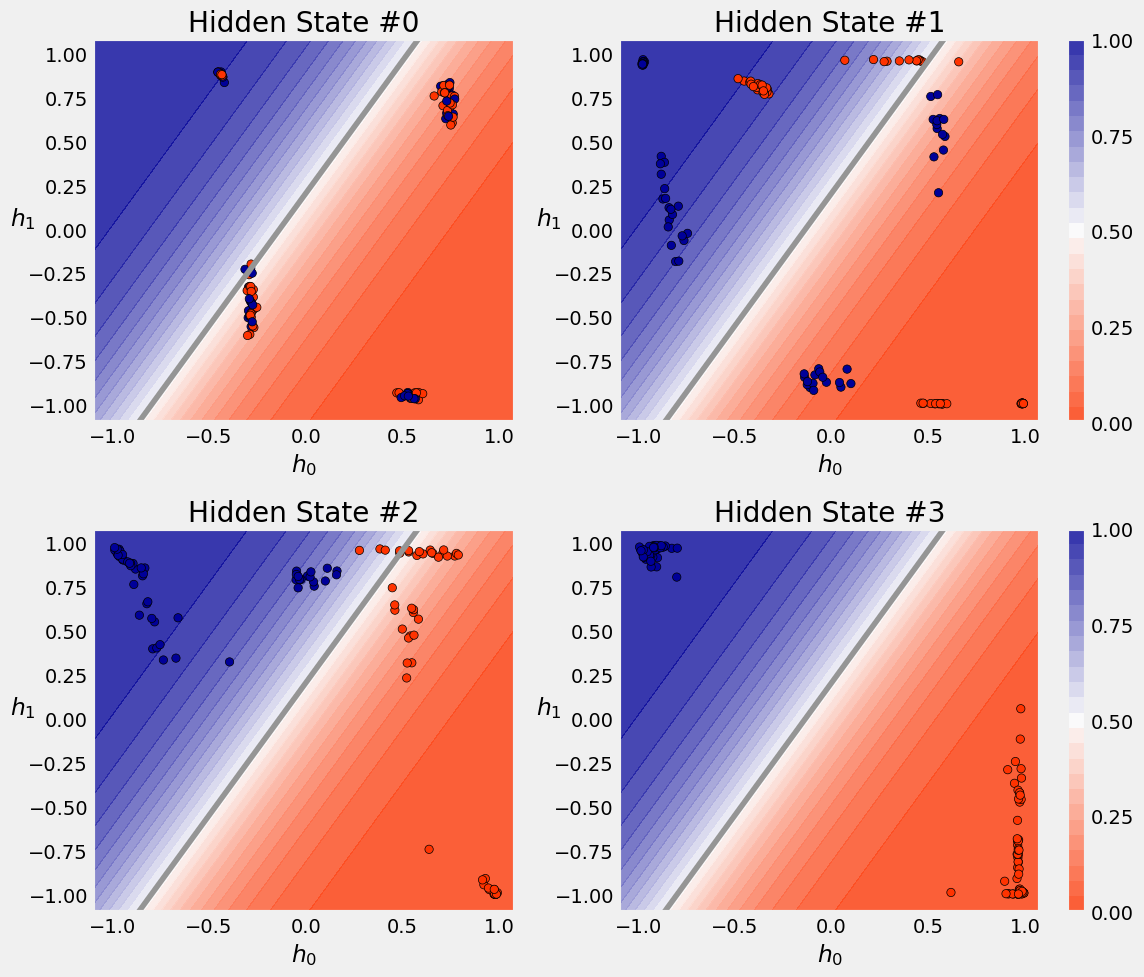

In [72]:
fig = hidden_states_contour(model, points, directions)

**Journey of a GATED Hidden State**

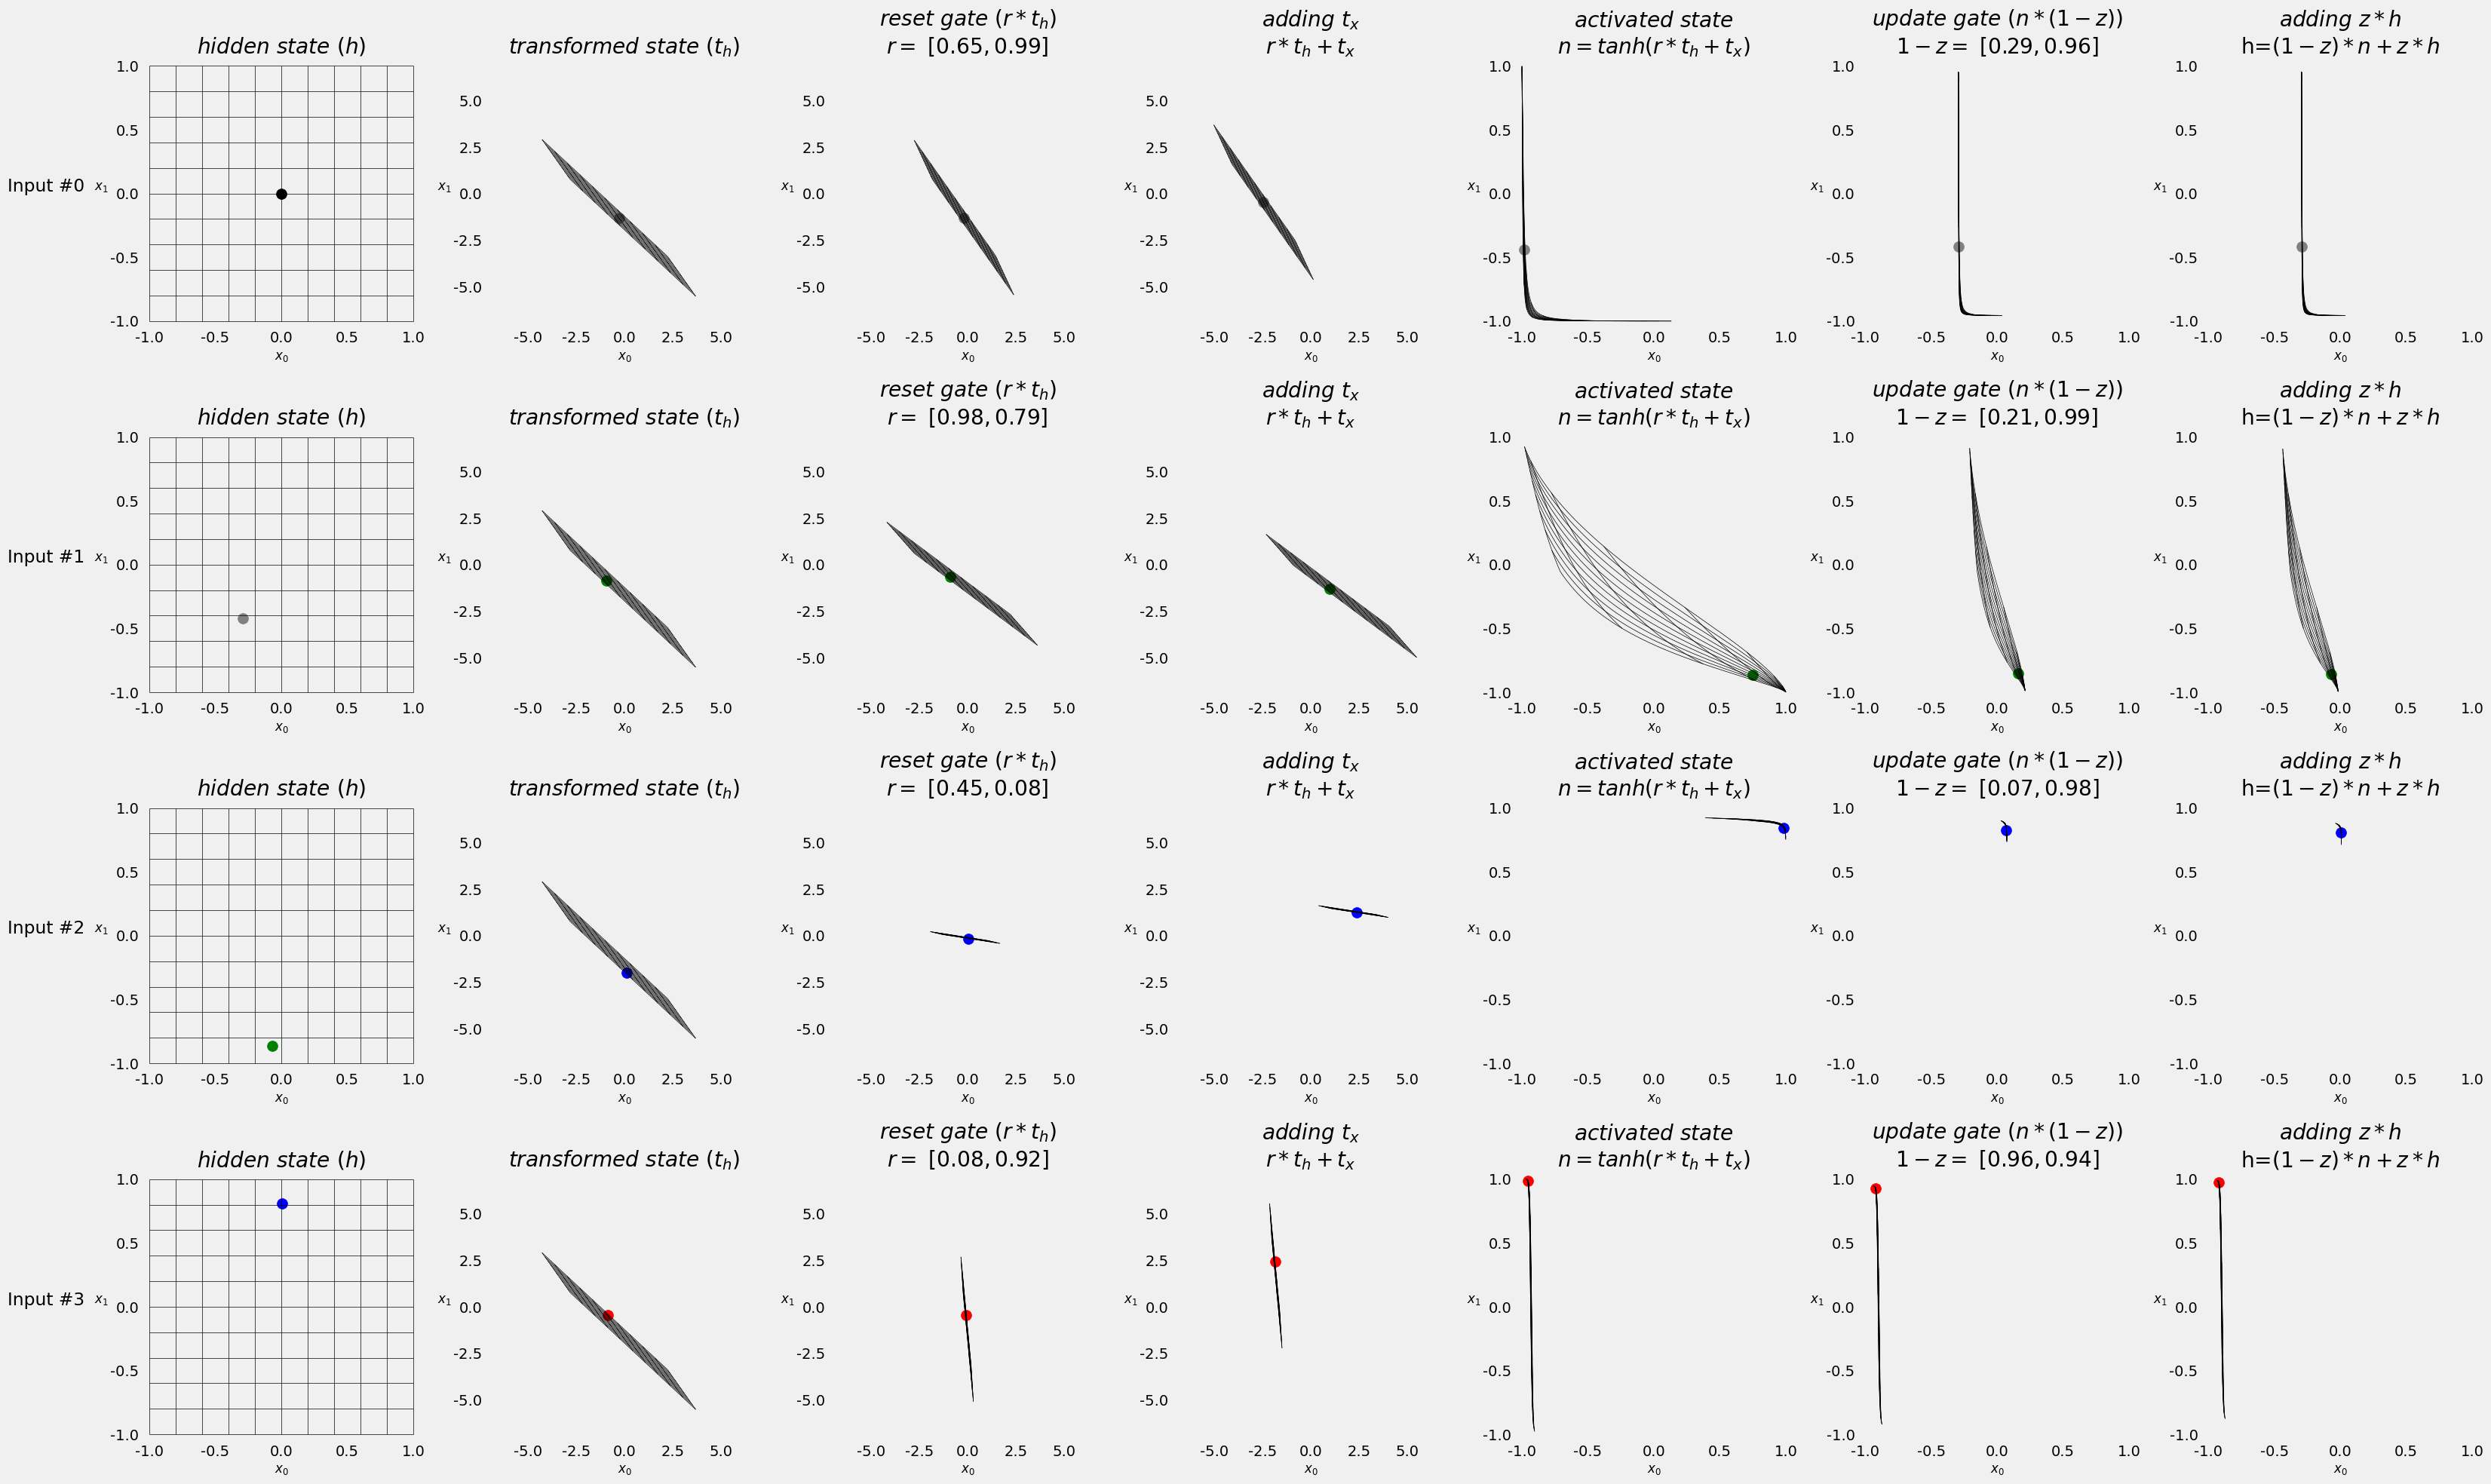

In [74]:
fig = figure22(model.basic_rnn)

## LSTM Layer ##

**Square Model III: The Sorcerer**

**Model Configuration**

In [75]:
class SquareModelLSTM(nn.Module):
    def __init__(self, n_features, hidden_dim, n_outputs):
        super(SquareModelLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.hidden = None
        self.cell = None
        # Simple LSTM
        self.basic_rnn = nn.LSTM(self.n_features, self.hidden_dim, batch_first=True) 
        # Classifier to produce as many logits as outputs        
        self.classifier = nn.Linear(self.hidden_dim, self.n_outputs)
                
    def forward(self, X):
        # X is batch first (N, L, F)
        # output is (N, L, H)
        # final hidden state is (1, N, H)
        # final cell state is (1, N, H)
        batch_first_output, (self.hidden, self.cell) = self.basic_rnn(X)
        
        # only last item in sequence (N, 1, H)
        last_output = batch_first_output[:, -1]
        # classifier will output (N, 1, n_outputs)
        out = self.classifier(last_output)
        
        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)

**Model Configuration & Training**

In [76]:
torch.manual_seed(21)
model = SquareModelLSTM(n_features=2, hidden_dim=2, n_outputs=1)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [77]:
sbs_lstm = StepByStep(model, loss, optimizer)
sbs_lstm.set_loaders(train_loader, test_loader)
sbs_lstm.train(100)

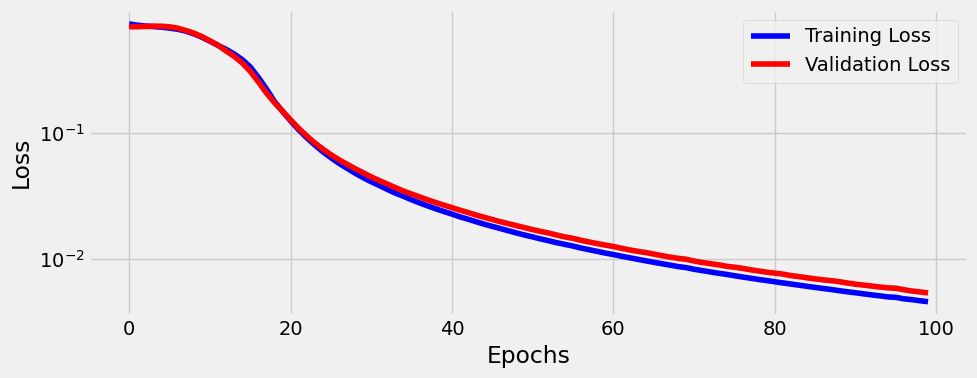

In [78]:
fig = sbs_lstm.plot_losses()

In [79]:
StepByStep.loader_apply(test_loader, sbs_lstm.correct)

tensor([[53, 53],
        [75, 75]])

## Visualizing the Hidden States ##

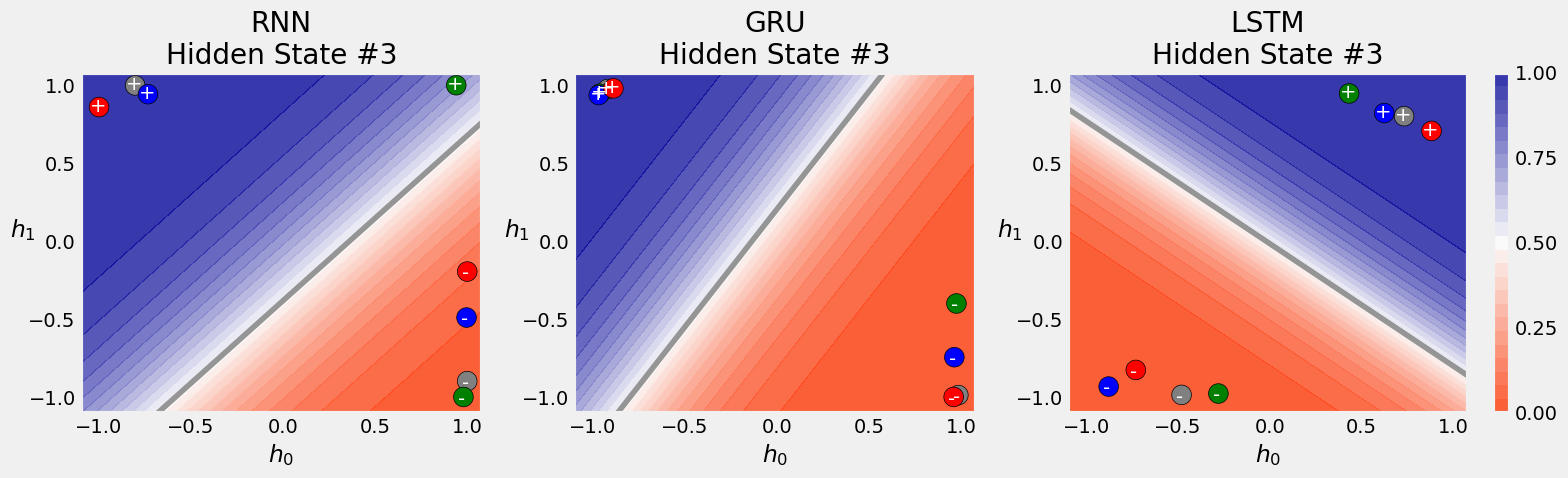

In [80]:
fig = figure25(sbs_rnn.model, sbs_gru.model, sbs_lstm.model)

## Variable-Length Sequences ##

In [81]:
s0 = points[0]      # 4 data points
s1 = points[1][2:]  # 2 data points
s2 = points[2][1:]  # 3 data points

s0.shape, s1.shape, s2.shape

((4, 2), (2, 2), (3, 2))

**Padding**

In [82]:
all_seqs = [s0, s1, s2]
torch.as_tensor(all_seqs)

ValueError: expected sequence of length 4 at dim 1 (got 2)

In [83]:
seq_tensors = [torch.as_tensor(seq).float() for seq in all_seqs]
padded = rnn_utils.pad_sequence(seq_tensors, batch_first=True)
padded

tensor([[[ 1.0349,  0.9661],
         [ 0.8055, -0.9169],
         [-0.8251, -0.9499],
         [-0.8670,  0.9342]],

        [[-1.0911,  0.9254],
         [-1.0771, -1.0414],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000]],

        [[-1.1247, -0.9683],
         [ 0.8182, -0.9944],
         [ 1.0081,  0.7680],
         [ 0.0000,  0.0000]]])

In [84]:
torch.manual_seed(11)
rnn = nn.RNN(2, 2, batch_first=True)

In [85]:
output_padded, hidden_padded = rnn(padded)
output_padded

tensor([[[-0.6388,  0.8505],
         [-0.4215,  0.8979],
         [ 0.3792,  0.3432],
         [ 0.3161, -0.1675]],

        [[ 0.2911, -0.1811],
         [ 0.3051,  0.7055],
         [ 0.0052,  0.5819],
         [-0.0642,  0.6012]],

        [[ 0.3385,  0.5927],
         [-0.3875,  0.9422],
         [-0.4832,  0.6595],
         [-0.1007,  0.5349]]], grad_fn=<TransposeBackward1>)

In [86]:
hidden_padded.permute(1, 0, 2)

tensor([[[ 0.3161, -0.1675]],

        [[-0.0642,  0.6012]],

        [[-0.1007,  0.5349]]], grad_fn=<PermuteBackward0>)

**Packing**

In [92]:
packed = rnn_utils.pack_sequence(seq_tensors, enforce_sorted=False)
packed

PackedSequence(data=tensor([[ 1.0349,  0.9661],
        [-1.1247, -0.9683],
        [-1.0911,  0.9254],
        [ 0.8055, -0.9169],
        [ 0.8182, -0.9944],
        [-1.0771, -1.0414],
        [-0.8251, -0.9499],
        [ 1.0081,  0.7680],
        [-0.8670,  0.9342]]), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=tensor([0, 2, 1]), unsorted_indices=tensor([0, 2, 1]))

In [93]:
(packed.data[[0, 3, 6, 8]] == seq_tensors[0]).all()

tensor(True)

In [94]:
output_packed, hidden_packed = rnn(packed)
output_packed, hidden_packed

(PackedSequence(data=tensor([[-0.6388,  0.8505],
         [ 0.3385,  0.5927],
         [ 0.2911, -0.1811],
         [-0.4215,  0.8979],
         [-0.3875,  0.9422],
         [ 0.3051,  0.7055],
         [ 0.3792,  0.3432],
         [-0.4832,  0.6595],
         [ 0.3161, -0.1675]], grad_fn=<CatBackward0>), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=tensor([0, 2, 1]), unsorted_indices=tensor([0, 2, 1])),
 tensor([[[ 0.3161, -0.1675],
          [ 0.3051,  0.7055],
          [-0.4832,  0.6595]]], grad_fn=<IndexSelectBackward0>))

In [95]:
hidden_packed == hidden_padded

tensor([[[ True,  True],
         [False, False],
         [False, False]]])

In [96]:
output_packed.data[[2, 5]] # x1 sequence

tensor([[ 0.2911, -0.1811],
        [ 0.3051,  0.7055]], grad_fn=<IndexBackward0>)

**Unpacking (to padded)**

In [97]:
output_unpacked, seq_sizes = rnn_utils.pad_packed_sequence(output_packed, batch_first=True)
output_unpacked, seq_sizes

(tensor([[[-0.6388,  0.8505],
          [-0.4215,  0.8979],
          [ 0.3792,  0.3432],
          [ 0.3161, -0.1675]],
 
         [[ 0.2911, -0.1811],
          [ 0.3051,  0.7055],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],
 
         [[ 0.3385,  0.5927],
          [-0.3875,  0.9422],
          [-0.4832,  0.6595],
          [ 0.0000,  0.0000]]], grad_fn=<IndexSelectBackward0>),
 tensor([4, 2, 3]))

In [98]:
output_unpacked[:, -1]

tensor([[ 0.3161, -0.1675],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000]], grad_fn=<SelectBackward0>)

In [99]:
seq_idx = torch.arange(seq_sizes.size(0))
output_unpacked[seq_idx, seq_sizes-1]

tensor([[ 0.3161, -0.1675],
        [ 0.3051,  0.7055],
        [-0.4832,  0.6595]], grad_fn=<IndexBackward0>)

**Packing (from padded)**

In [100]:
len_seqs = [len(seq) for seq in all_seqs]
len_seqs

[4, 2, 3]

In [101]:
packed = rnn_utils.pack_padded_sequence(padded, len_seqs, enforce_sorted=False, batch_first=True)
packed

PackedSequence(data=tensor([[ 1.0349,  0.9661],
        [-1.1247, -0.9683],
        [-1.0911,  0.9254],
        [ 0.8055, -0.9169],
        [ 0.8182, -0.9944],
        [-1.0771, -1.0414],
        [-0.8251, -0.9499],
        [ 1.0081,  0.7680],
        [-0.8670,  0.9342]]), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=tensor([0, 2, 1]), unsorted_indices=tensor([0, 2, 1]))

**Variable-Length Dataset**

In [102]:
var_points, var_directions = generate_sequences(variable_len=True)
var_points[:2]

[array([[ 1.12636495,  1.1570899 ],
        [ 0.87384513, -1.00750892],
        [-0.9149893 , -1.09150317],
        [-1.0867348 ,  1.07731667]]),
 array([[ 0.92250954, -0.89887678],
        [ 1.0941646 ,  0.92300589]])]